==================== Question 1 ====================

cosine distance:

Cluster 0:
 game; england; win; cup; team; match; injury; players; first; ireland; play; side; wales; season; coach; world; chelsea; rugby; club; year
Cluster 1:
 us; growth; economy; sales; year; oil; market; bank; company; shares; 2004; china; economic; firm; dollar; prices; analysts; yukos; government; india
Cluster 2:
 film; best; show; awards; award; music; festival; year; star; us; band; actor; album; oscar; tv; films; chart; director; actress; one
Cluster 3:
 mr; labour; election; blair; party; government; would; brown; minister; howard; people; tax; prime; tory; chancellor; public; tories; lord; lib; plans
Cluster 4:
 people; mobile; technology; users; software; net; digital; games; broadband; music; microsoft; use; computer; online; video; phone; mr; service; phones; tv


              precision    recall  f1-score   support

           1       0.97      0.96      0.96        96
           2       0.97    

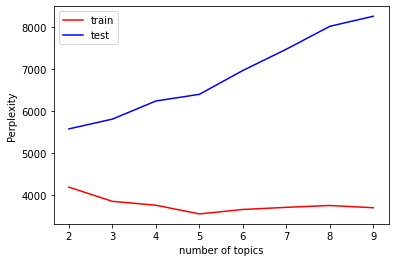

Here we simply apply perplexity to reflect the variance among each topic, the lower, the better.
While it's hard to decide which one would be best for test set, for training set, the best number of topics would be 5.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.cluster import KMeansClusterer, cosine_distance, euclidean_distance
from nltk.corpus import stopwords

if __name__ == "__main__":  
    
    # Due to randomness, you won't get the exact result
    # as shown here, but your result should be close
    # if you tune the parameters carefully
    
    train = pd.read_csv("hw6_train.csv")
    test = pd.read_csv("hw6_test.csv")

    
    # Q1
    
    def cluster_kmean(train_text, test_text,  num_clusters = 2, distance ='cosine_distance'):
    
        predict = None

        stop = stopwords.words('english')+['said']
        tf = TfidfVectorizer(stop_words=stop, min_df=2)
        tfidf = tf.fit_transform(train_text)

        cl = KMeansClusterer(num_clusters, eval(distance), repeats=20, avoid_empty_clusters=True)
        train_cl = cl.cluster(tfidf.toarray(), assign_clusters=True)
        voc = tf.get_feature_names()

        for i in range(num_clusters):  
            top = [voc[x] for x in cl.means()[i].argsort()[::-1][:20]]
            print('Cluster {}:\n {}'.format(i, "; ".join(top)))

        tfidf_test = tf.transform(test_text)
        predict = [cl.classify(x) for x in tfidf_test.toarray()]

        return predict
            
    def external_evaluate(pred_clusters, test_labels):

        df = pd.DataFrame(list(zip(test_labels.values, pred_clusters)), columns=['label', 'cluster'])
        mapping = pd.crosstab(index=df.cluster, columns=df.label)
        idx=mapping.idxmax(axis=1)
        pre = [idx[i] for i in pred_clusters]

        print(classification_report(test_labels, pre, zero_division=0))
        
    print('='*20, 'Question 1', '='*20)
    print('\ncosine distance:\n')
    pre_cl1 = cluster_kmean(train["text"], test['text'], num_clusters=5, distance='cosine_distance')
    print('\n')
    external_evaluate(pre_cl1, test['label'])
    print('\neuclidean distance:\n') 
    pre_cl2 = cluster_kmean(train["text"], test['text'], num_clusters=5, distance='euclidean_distance')
    print('\n')
    external_evaluate(pre_cl2, test['label']) 
    print('\n')
    
    # Q2
    
    def cluster_gmm(train_text, test_text, num_clusters=2, cv_type='diag'):
    
        predict = None

        stop = stopwords.words('english')+['said']
        tf = TfidfVectorizer(stop_words=stop, min_df=2)
        tfidf = tf.fit_transform(train_text)

        gmm = GaussianMixture(n_components=num_clusters, covariance_type=cv_type, n_init=5, random_state=777)
        gmm.fit(tfidf.toarray())
        voc = tf.get_feature_names()

        for i in range(num_clusters):  
            top = [voc[x] for x in gmm.means_[i].argsort()[::-1][:20]]
            print('Cluster {}:\n {}'.format(i, "; ".join(top)))

        tfidf_test = tf.transform(test_text)
        predict = gmm.predict(tfidf_test.toarray())

        return predict
    
    print('='*20, 'Question 2', '='*20)   
    print('\ncovariance_type = diag:\n')
    pre_gmm_diag = cluster_gmm(train["text"], test['text'], num_clusters=5)
    print('\n')
    external_evaluate(pre_gmm_diag, test['label'])
    print('\ncovariance_type = spherical:\n')
    pre_gmm_sph = cluster_gmm(train["text"], test['text'], num_clusters=5, cv_type='spherical')
    print('\n')
    external_evaluate(pre_gmm_sph, test['label'])
    print('\n')
    
    # Q3
    
    def cluster_lda(train_text, test_text, num_clusters=2):

        predict = None

        stop = stopwords.words('english')+['said']
        cv = CountVectorizer(stop_words=stop, min_df=2)
        tf = cv.fit_transform(train_text)

        lda = LDA(n_components=num_clusters, max_iter=30, n_jobs=-1, random_state=777)
        lda.fit(tf)
        voc = cv.get_feature_names()

        for i in range(num_clusters):  
            top = [voc[x] for x in lda.components_[i].argsort()[::-1][:20]]
            print('Cluster {}:\n {}'.format(i, "; ".join(top)))

        tf_test = cv.transform(test_text)
        pred = lda.transform(tf_test)
        predict = [x.argmax() for x in pred]

        return predict

    print('='*20, 'Question 3', '='*20)   
    print('\nLDA:\n')
    pre_lda = cluster_lda(train["text"], test['text'], num_clusters=5)
    print('\n')
    external_evaluate(pre_lda, test['label'])
    print('\n')
        
    # Q4
    
    stop = stopwords.words('english')+['said']
    cv = CountVectorizer(stop_words=stop, min_df=2)
    tf = cv.fit_transform(train.text)
    tf_test = cv.transform(test.text)

    lis_train = []
    lis_test = []
    for num_topics in range(2,10):
        lda = LDA(n_components=num_topics, max_iter=30, n_jobs=-1, random_state=777).fit(tf)
        p = lda.perplexity(tf)
        p1 = lda.perplexity(tf_test)
        lis_train.append(p)
        lis_test.append(p1)
    
    print('='*20, 'Question 4', '='*20) 
    plt.figure()
    plt.xlabel('number of topics')
    plt.ylabel('Perplexity')
    plt.plot(list(range(2, 10)), lis_train, color='r', label='train')
    plt.plot(list(range(2, 10)), lis_test, color='b', label='test')
    plt.legend()
    plt.show()
    print('Here we simply apply perplexity to reflect the variance among each topic, the lower, the better.')
    print("While it's hard to decide which one would be best for test set, for training set, the best number of topics would be 5.")